# Estimation of MET cross section with Madgraph 3.6.2

## Import MG5 and dependencies

In [28]:
import os
import sys
sys.path.append('../src') # Only if madpy is not installed
#from madpy import madpy_generate_script, convert_eps_to_pdf, madpy_run
from dataclasses import dataclass
import pandas as pd 

import tarfile
import os
import subprocess
from subprocess import Popen, PIPE, CalledProcessError
from pathlib import Path
import sys

MADGRAPH_PATH = f"../mg5amcnlo"
sys.path.append(MADGRAPH_PATH)

In [ ]:
from pathlib import Path



## Install models and plugins

### [ALPsEFT](https://feynrules.irmp.ucl.ac.be/wiki/ALPsEFT)



In [30]:

## Parameters

workdir_path = "./workdir"
process_name = "ALP_TT"
process =  "p p > t t~ a"
model =  "Axion_EFT_UFO"
process_name = process_name
process_dir = process_name
number_events = 1000000
sm_coupling_value = 0.25
decays = {"9000001": "Auto",
        "9000002": "Auto",
        "9000003": "Auto",
        "9000004": "Auto"}
masses_dict = {"maxion": 1000}
decays = None
# dm_coup_list = ['gsxr', "gsxc", 'gsxd', 'gpxd']
# sm_coup_list = ["gsd11", "gsu11", "gsd22", "gsu22", "gsd33", "gsu33", "gpd11", "gpu11", "gpd22",
#                 "gpu22", "gpd33", "gpu33", "gsg", "gpg", "gsh1", "gsh2", "gsb", "gpb", "gsw", "gpw"]
dm_coup_list = ['gSXd', "gSXc ", 'gsxr']
sm_coup_list = ["gSe"]


In [31]:
full_script_str, mg5_script_path, workdir_process = madpy_generate_script(process = process,
                                                        model = model,
                                                        process_name = process_name,
                                                        masses = masses_dict,
                                                        #coupling = coups_dict,
                                                        #decays = decays,
                                                        pt_cut = None,
                                                        madspin = False, ## For e+e-, madspin = False
                                                        workdir_path = workdir_path,
                                                        number_events = number_events,
                                                         )

#mg5_script_complete_path = madpy_run(process_name, mg5_script_folder_path = ".")

In [32]:
mg5_script_complete_path = madpy_run(process_name, mg5_script_folder_path = f".")

Check the mg5 log on ALP_TT.log


KeyboardInterrupt: 

In [9]:
convert_from_folder(workdir_process, workdir_process+'/diagrams')


Found 5 EPS file(s) to convert

Converting: diagrams_1_gg_ttxa.eps → diagrams_1_gg_ttxa.pdf
Successfully converted workdir/ALP_TT/diagrams_1_gg_ttxa.eps to workdir/ALP_TT/diagrams/diagrams_1_gg_ttxa.pdf

Converting: diagrams_1_ccx_ttxa.eps → diagrams_1_ccx_ttxa.pdf
Successfully converted workdir/ALP_TT/diagrams_1_ccx_ttxa.eps to workdir/ALP_TT/diagrams/diagrams_1_ccx_ttxa.pdf

Converting: diagrams_1_ssx_ttxa.eps → diagrams_1_ssx_ttxa.pdf
Successfully converted workdir/ALP_TT/diagrams_1_ssx_ttxa.eps to workdir/ALP_TT/diagrams/diagrams_1_ssx_ttxa.pdf

Converting: diagrams_1_ddx_ttxa.eps → diagrams_1_ddx_ttxa.pdf
Successfully converted workdir/ALP_TT/diagrams_1_ddx_ttxa.eps to workdir/ALP_TT/diagrams/diagrams_1_ddx_ttxa.pdf

Converting: diagrams_1_uux_ttxa.eps → diagrams_1_uux_ttxa.pdf
Successfully converted workdir/ALP_TT/diagrams_1_uux_ttxa.eps to workdir/ALP_TT/diagrams/diagrams_1_uux_ttxa.pdf

Conversion complete! 0/5 files converted.
Output folder: workdir/ALP_TT/diagrams


## Read info from generated files

### Unpack lhe files

In [ ]:
import subprocess
import os
import pandas as pd
#import mplhep as hep
import numpy as np
import matplotlib.pyplot as plt


lhe_file = workdir_process + "/Events/run_01/unweighted_events.lhe.gz"


output_lhe_file = unpack_events(lhe_file)
output_lhe_file


Arquivo LHE descompactado com sucesso.


PosixPath('workdir/ALP_TT/Events/run_01/unweighted_events.lhe')

In [83]:
lhe_file

'./workdir/ALP_TT/Events/run_01/unweighted_events.lhe.gz'

In [87]:
# Extract cross section from LHE file
def get_cross_section(lhe_file):
    cross_section = None
    with open(lhe_file, 'r') as file:
        in_init_block = False
        for line in file:
            if "<init>" in line:
                in_init_block = True
            elif "</init>" in line:
                in_init_block = False
                break
            elif in_init_block:
                data = line.strip().split()
                if len(data) <= 6:
                    cross_section = float(data[0]) 
                    error = float(data[1])
                    break
    return cross_section, error

# Extract the events and convert it to pandas format
def parse_lhe_file(file_path, cross_section, error, run_number=None):
    events = []
    event_id = 0

    with open(file_path, 'r') as file:
        in_event = False
        for line in file:
            if "<event>" in line:
                in_event = True
                event = []
                event_id += 1  # Incrementa o ID do evento a cada novo evento
            elif "</event>" in line:
                in_event = False
                events.append(event)
            elif in_event:
                data = line.strip().split()
                if len(data) >= 6:
                    try:
                        particle_data = list(map(float, data))
                        particle_data.append(event_id)  # Adiciona o ID do evento à partícula
                        event.append(particle_data)
                    except ValueError:
                        #print("line ", line)
                        #print("event id ", event_id)
                        #print('particle data ', particle_data)
                        #print('error in line ', data)
                        pass


                        # TODO: How to extract this info 
                        # <mgrwt>
                        # <rscale>  0 0.43702855E+04</rscale>
                        # <asrwt>0</asrwt>
                        # <pdfrwt beam="1">  1        2 0.25919763E+00 0.43702855E+04</pdfrwt>
                        # <pdfrwt beam="2">  1       -2 0.32749606E+00 0.43702855E+04</pdfrwt>
                        # <totfact> 0.16864895E-01</totfact>
                        # </mgrwt>

            
    # Converte a lista de eventos para um DataFrame
    columns = ["pid", "status", "m_mother1", "mother2", "color1", "color2", "px", "py", "pz", "E", "M", "lifetime", "spin", "event_id"]
    df = pd.DataFrame([item for sublist in events for item in sublist], columns=columns)
    # Adiciona uma coluna de cross-section (mesmo valor para todos os eventos)
    df["cross_section"] = cross_section #pb
    df["cross_section_error"] = error #± pb
    df.dropna(subset=["lifetime", "spin"], inplace=True)
    
    if run_number:
        df['run_number'] = run_number
        

    return df, events

# Extraia a cross-section do arquivo LHE
cross_section_value, cross_section_error = get_cross_section(output_lhe_file)
print(f'Cross section of the run: {cross_section_value} pb +/- {cross_section_error} pb' )


Cross section of the run: 17748.13 pb +/- 52.67008 pb


In [ ]:
df_events, _ = parse_lhe_file(output_lhe_file, cross_section_value, cross_section_error, run_number=1)
# df_events_merged = pd.concat([df_events_merged, df_events])


### Subtitles for the PIDs

In [92]:
total_cross_section = df_events.cross_section.iloc[0] * 1000 # converts to fb
total_cross_section_error = df_events.cross_section_error.iloc[0]
print(total_cross_section, total_cross_section_error)

17748130.0 52.67008


In [ ]:
# TODO: Plot the results

## Plotting the mg5 / lhe results

In [ ]:
import mplhep as hep
# ZZ, a pair of heavier bosons.

def get_hist_bins(df_to_plot, bin_gev):
    
    gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
    M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
    # the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions
    hist, bins = M_hist  # hist=frequency ; bins=Mass values
    return hist, bins
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()
hist1, bins1 = get_hist_bins(df_to_plot, 10)
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()

hist1, bins1 = get_hist_bins(df_to_plot, 10)
fig, ax = plt.subplots(figsize=(10, 5))
bin_gev = 5

hep.histplot(
    [hist1, hist1],
    bins=bins1,
    histtype="fill",
    stack=True,
    color=["b", "r"],
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


In [ ]:

# ZZ, a pair of heavier bosons.
## converts to cross section
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy() 
bin_gev = 0.1
#gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=10000) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions


hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="b",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()


In [22]:
hist_df = pd.DataFrame(M_hist).T.rename(columns={0: 'nevents', 1: 'energy_nu'})

In [23]:
hist_df['xsec'] = hist_df['nevents'] * total_cross_section /1000000

In [24]:
hist_df['integrated_xsec'] = 0
xsec_met = {}
for energy in range(1000, 6000, 100):
    xsec_met[energy] = hist_df.loc[hist_df['energy_nu'].between(energy, energy+100), 'xsec'].sum()


In [25]:
energy_xsec_df = pd.DataFrame.from_dict(xsec_met, orient='index', columns=['xsec_met']).reset_index().rename(columns={'index': 'energy_nu'}) 

In [26]:
energy_xsec_df.to_csv('energy_met_xsec.csv', index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
ax.plot(energy_xsec_df['energy_nu'], energy_xsec_df['xsec_met'])
ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()

In [ ]:
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

hep.style.use("CMS")
# ZZ, a pair of heavier bosons.
df_to_plot = df_gp.loc[df_gp['PID'].isin([22]), 'E'].to_numpy()
df_to_plot
bin_gev = 100
gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions

hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="y",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\gamma$ energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


In [ ]:
df_gp.loc[df_gp['PID'].isin([12]), 'E'].hist(bins=50)#.set_xlim(1000, 1500)


(1000.0, 1500.0)

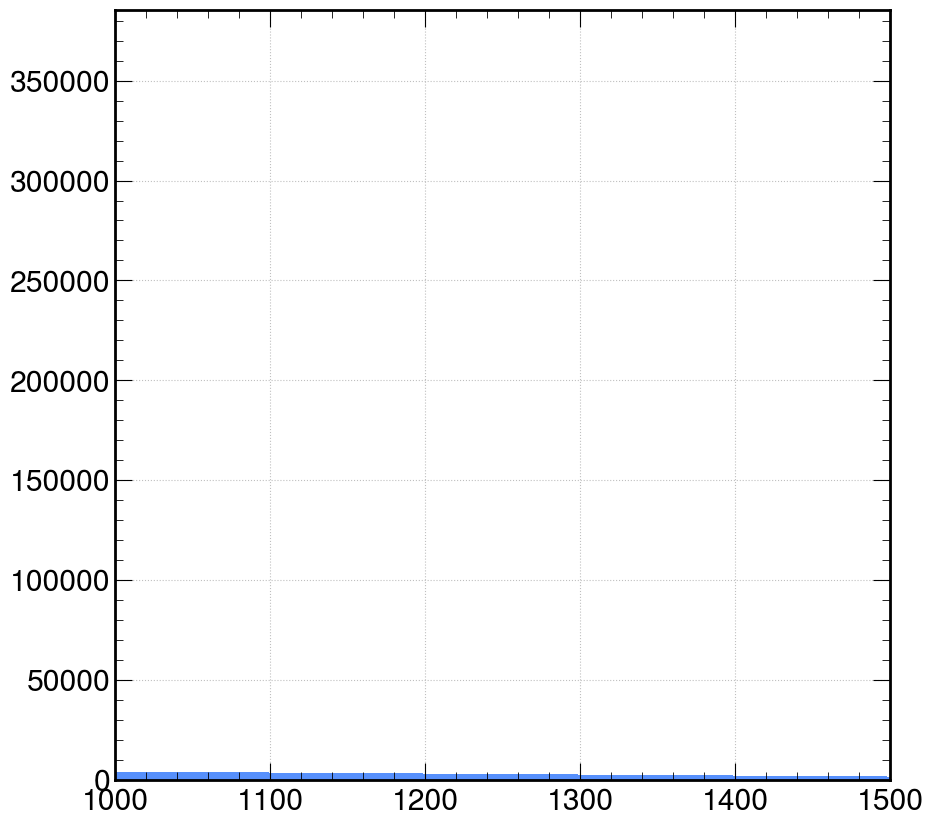

In [32]:
df_events.loc[df_events['PID'].isin([12, -12]), 'E'].hist(bins=50).set_xlim(1000, 1500)

array([[<Axes: title={'center': 'E'}>]], dtype=object)

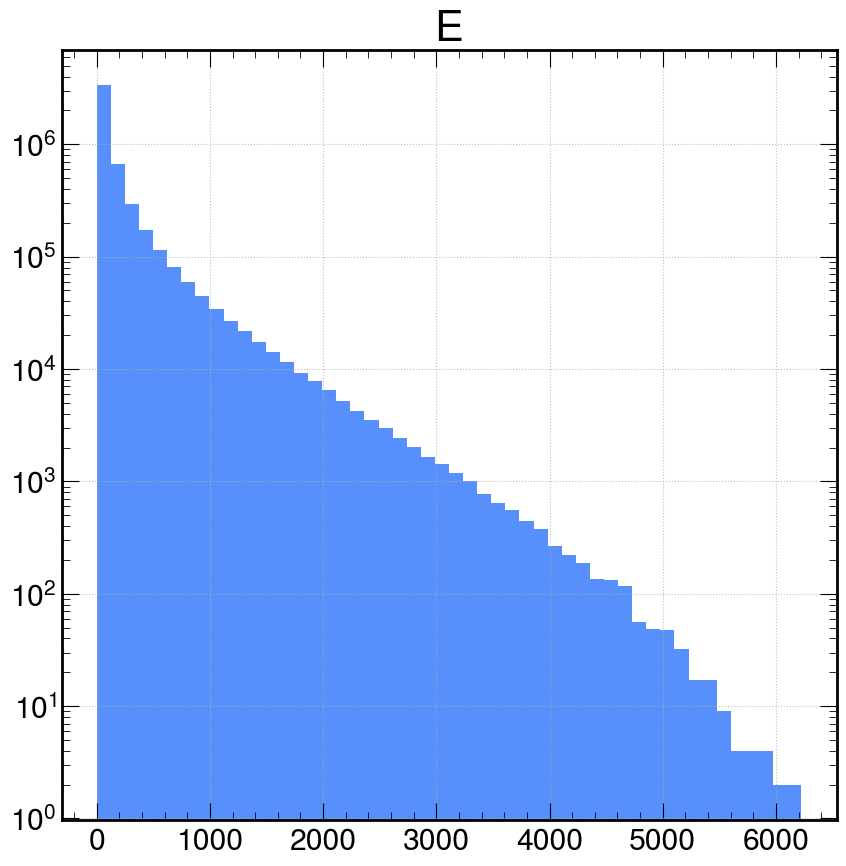

In [34]:
df_events.hist('E', bins=50, log=True)